# Digital Image Fundamentals

## Overview
- Comprehensive exploration of digital image representation, color theory, and file formats
- Learn core concepts behind digital image processing and computer vision
- Understand technical aspects of image handling and storage

## Dependencies

In [39]:
# Standard imports - Adding data science libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
from scipy import stats
import plotly.express as px  # For interactive visualizations
from skimage import io, exposure
from typing import Union, Tuple, List, Optional, Dict
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

# Configure matplotlib
%matplotlib inline
plt.style.use('seaborn')

/var/folders/l3/ydlbbfvj1bg_xldxmdjf0kqr0000gn/T/ipykernel_59663/699764219.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Theoretical Background

### Digital Image Representation

A digital image is a two-dimensional array of pixels, where each pixel represents a discrete sample of visual information. The fundamental aspects include:

#### Pixels and Coordinate Systems
- Images use a coordinate system where (0,0) is typically at the top-left corner
- The x-axis extends horizontally (columns) and y-axis vertically (rows)
- Each pixel location is addressed by its (x,y) coordinates

#### Bit Depth and Dynamic Range
- Bit depth determines the number of distinct colors/intensities possible
- Common bit depths:
  - 8-bit: 256 levels (0-255)
  - 16-bit: 65,536 levels
  - 24-bit: 16.7 million colors (8 bits per RGB channel)
- Dynamic range represents the ratio between maximum and minimum measurable light intensities

#### Image Resolution and Aspect Ratio
- Resolution describes pixel dimensions (width × height)
- Spatial resolution refers to pixels per unit area (e.g., DPI/PPI)
- Aspect ratio is the proportional relationship between width and height

### Color Theory

#### Color Spaces
- Different mathematical models for representing color
- Each serves specific purposes in image processing
- Common color spaces include RGB, HSV, and LAB

#### Color Quantization
- Process of reducing number of distinct colors
- Important for compression and visualization
- Involves selecting representative colors and mapping similar colors

#### Gamma Correction
- Nonlinear operation used to encode/decode luminance
- Compensates for display device characteristics
- Critical for accurate color reproduction

### Image File Formats
- Various formats optimize different aspects:
  - Quality vs compression
  - Feature support (transparency, animation)
  - Compatibility and standardization

In [40]:
class ImageFundamentals:
    """Class demonstrating basic digital image concepts"""
    
    def __init__(self):
        """Initialize with example image data"""
        # Create simple gradient image for demonstrations
        self.gradient = np.linspace(0, 1, 256)
        self.gradient = np.tile(self.gradient, (256, 1))
        
    def demonstrate_bit_depth(self):
        """Show effects of different bit depths"""
        # Original 8-bit gradient
        gradient_8bit = (self.gradient * 255).astype(np.uint8)
        
        # Simulate lower bit depths
        bit_depths = [1, 2, 4, 6, 8]
        fig, axes = plt.subplots(len(bit_depths), 1, figsize=(10, 3*len(bit_depths)))
        
        for ax, bits in zip(axes, bit_depths):
            levels = 2**bits
            gradient_reduced = np.round(self.gradient * (levels-1)) / (levels-1)
            ax.imshow(gradient_reduced, cmap='gray')
            ax.set_title(f'{bits}-bit depth ({levels} levels)')
            ax.axis('off')
        
        plt.tight_layout()
        return fig
    
    def demonstrate_color_spaces(self, image_path):
        """Show image in different color spaces"""
        # Load image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Convert to different color spaces
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        
        # Display results
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        axes = axes.ravel()
        
        # RGB
        axes[0].imshow(img)
        axes[0].set_title('RGB')
        
        # HSV channels
        axes[1].imshow(hsv[:,:,0], cmap='hsv')
        axes[1].set_title('HSV - Hue Channel')
        
        # LAB channels
        axes[2].imshow(lab[:,:,0], cmap='gray')
        axes[2].set_title('LAB - Lightness Channel')
        
        # Gamma correction example
        gamma = 2.2
        gamma_corrected = np.power(img/255.0, gamma)
        axes[3].imshow(gamma_corrected)
        axes[3].set_title(f'Gamma Correction (γ={gamma})')
        
        for ax in axes:
            ax.axis('off')
        
        plt.tight_layout()
        return fig
    
class ImagePreprocessor:
    """Handles image preprocessing and standardization tasks."""
    
    def __init__(self, 
                 output_size: Tuple[int, int] = (1024, 1024),
                 resize_method: str = 'bicubic',
                 normalize: bool = True,
                 color_mode: str = 'rgb',
                 padding_color: Tuple[int, int, int] = (0, 0, 0)):
        """
        Initialize the image preprocessor.
        
        Args:
            output_size: Target size for processed images
            resize_method: Method for resizing ('nearest', 'bilinear', 'bicubic', 'lanczos')
            normalize: Whether to normalize pixel values to [0,1]
            color_mode: Target color mode ('rgb', 'bgr', 'grayscale')
            padding_color: Color to use for padding (RGB)
        """
        self.output_size = output_size
        self.resize_method = resize_method
        self.normalize = normalize
        self.color_mode = color_mode.lower()
        self.padding_color = padding_color
        
        # Set up logging
        self.logger = logging.getLogger(__name__)
        self._setup_logging()
        
        # Initialize parameters
        self._init_parameters()
        
    def _setup_logging(self):
        """Configure logging settings."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
    
    def _init_parameters(self):
        """Initialize internal parameters and validate settings."""
        # Supported image formats
        self.supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        
        # Resize filter mapping
        self.filter_map = {
            'nearest': Image.NEAREST,
            'bilinear': Image.BILINEAR,
            'bicubic': Image.BICUBIC,
            'lanczos': Image.LANCZOS
        }
        
        # Validate and set resize method
        if self.resize_method.lower() not in self.filter_map:
            self.logger.warning(f"Invalid resize method '{self.resize_method}'. Using 'bicubic'.")
            self.resize_method = 'bicubic'
        
        self.resample_filter = self.filter_map[self.resize_method.lower()]
    
    def process_single_image(self, image_path: Union[str, Path], 
                            save_path: Optional[Union[str, Path]] = None) -> np.ndarray:
        """
        Process a single image file.
        """
        try:
            # Load image
            img = Image.open(image_path)
            
            # Convert color mode
            if self.color_mode == 'grayscale':
                img = img.convert('L')
            else:
                img = img.convert('RGB')
            
            # Resize while preserving aspect ratio
            img_resized = self._resize_preserve_aspect(img)
            
            # Convert to numpy array
            img_array = np.array(img_resized)
            
            # Normalize if requested
            if self.normalize:
                img_array = img_array.astype(np.float32) / 255.0
            else:
                img_array = img_array.astype(np.uint8)
            
            # Handle color mode conversion
            if self.color_mode == 'bgr' and len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            
            # Save if path provided
            if save_path:
                self._save_processed_image(img_resized, save_path)
            
            return img_array
            
        except Exception as e:
            self.logger.error(f"Error processing {image_path}: {str(e)}")
            raise
    def process_directory(self, 
                         input_dir: Union[str, Path],
                         output_dir: Optional[Union[str, Path]] = None,
                         recursive: bool = False) -> Dict[str, np.ndarray]:
        """
        Process all images in a directory.
        
        Args:
            input_dir: Input directory path
            output_dir: Optional output directory path
            recursive: Whether to process subdirectories
            
        Returns:
            Dictionary of processed images {filename: image_array}
        """
        input_dir = Path(input_dir)
        if output_dir:
            output_dir = Path(output_dir)
            output_dir.mkdir(parents=True, exist_ok=True)
        
        # Collect image files
        pattern = '**/*' if recursive else '*'
        image_files = [f for f in input_dir.glob(pattern) 
                      if f.suffix.lower() in self.supported_formats]
        
        if not image_files:
            self.logger.warning(f"No supported image files found in {input_dir}")
            return {}
        
        processed_images = {}
        for image_path in tqdm(image_files, desc="Processing images"):
            try:
                if output_dir:
                    save_path = output_dir / image_path.name
                else:
                    save_path = None
                
                processed = self.process_single_image(image_path, save_path)
                processed_images[image_path.name] = processed
                
            except Exception as e:
                self.logger.error(f"Error processing {image_path.name}: {str(e)}")
                continue
        
        return processed_images
    
    def _resize_preserve_aspect(self, image: Image.Image) -> Image.Image:
        """Resize image preserving aspect ratio with padding."""
        original_width, original_height = image.size
        aspect_ratio = original_width / original_height
        
        if aspect_ratio > 1:
            new_width = self.output_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = self.output_size[1]
            new_width = int(new_height * aspect_ratio)
        
        # Resize the image
        img_resized = image.resize((new_width, new_height), self.resample_filter)
        
        # Create background with padding color
        background = Image.new(image.mode, self.output_size, self.padding_color)
        
        # Calculate position to paste
        paste_x = (self.output_size[0] - new_width) // 2
        paste_y = (self.output_size[1] - new_height) // 2
        
        # Paste resized image onto background
        background.paste(img_resized, (paste_x, paste_y))
        
        return background
    
    def _save_processed_image(self, image: Image.Image, save_path: Union[str, Path]):
        """Save processed image with optimization."""
        save_path = Path(save_path)
        
        # Create directory if it doesn't exist
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Save with appropriate settings
        if save_path.suffix.lower() in {'.jpg', '.jpeg'}:
            image.save(save_path, quality=95, optimize=True)
        else:
            image.save(save_path, optimize=True)

class ImageAugmentor:
    """Utility class for image augmentation."""
    
    @staticmethod
    def rotate(image: np.ndarray, angle: float) -> np.ndarray:
        """Rotate image by given angle."""
        rows, cols = image.shape[:2]
        matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image, matrix, (cols, rows))
    
    @staticmethod
    def flip(image: np.ndarray, direction: str = 'horizontal') -> np.ndarray:
        """Flip image horizontally or vertically."""
        if direction == 'horizontal':
            return cv2.flip(image, 1)
        elif direction == 'vertical':
            return cv2.flip(image, 0)
        else:
            raise ValueError("direction must be 'horizontal' or 'vertical'")
    
    @staticmethod
    def adjust_brightness(image: np.ndarray, factor: float) -> np.ndarray:
        """Adjust image brightness."""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hsv = hsv.astype(np.float32)
        hsv[:,:,2] = hsv[:,:,2] * factor
        hsv[:,:,2] = np.clip(hsv[:,:,2], 0, 255)
        hsv = hsv.astype(np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

class ImageAnalyzer:
    """Utility class for image analysis and quality assessment."""
    
    @staticmethod
    def compute_histogram(image: np.ndarray, channels: List[int] = None,
                         bins: int = 256, range_: tuple = (0, 256)) -> Dict[str, np.ndarray]:
        """
        Compute image histogram for specified channels.
        
        Args:
            image: Input image
            channels: List of channels to compute histograms for
            bins: Number of histogram bins
            range_: Range of values to include
            
        Returns:
            Dictionary of histograms for each channel
        """
        if channels is None:
            if len(image.shape) == 2:
                channels = [0]
            else:
                channels = list(range(image.shape[2]))
        
        histograms = {}
        for channel in channels:
            hist = cv2.calcHist([image], [channel], None, [bins], range_)
            histograms[f'channel_{channel}'] = hist.ravel()
            
        return histograms
    
    @staticmethod
    def compute_statistics(image: np.ndarray) -> Dict[str, Union[float, np.ndarray]]:
        """
        Compute comprehensive image statistics.
        
        Returns dictionary containing:
        - Basic statistics (mean, std, min, max)
        - Dynamic range
        - Signal-to-noise ratio (SNR)
        - Root mean square (RMS)
        """
        stats = {
            'mean': np.mean(image, axis=(0,1)),
            'std': np.std(image, axis=(0,1)),
            'min': np.min(image, axis=(0,1)),
            'max': np.max(image, axis=(0,1)),
            'dynamic_range': np.ptp(image, axis=(0,1)),
            'rms': np.sqrt(np.mean(np.square(image), axis=(0,1)))
        }
        
        # Compute SNR if image is not empty
        if np.any(stats['std'] != 0):
            stats['snr'] = np.mean(stats['mean'] / stats['std'])
        else:
            stats['snr'] = float('inf')
            
        return stats
    
    @staticmethod
    def assess_quality(image: np.ndarray) -> Dict[str, float]:
        """
        Assess image quality using various metrics.
        Handles both normalized [0,1] and uint8 [0,255] images.
        """
        # Convert normalized images to uint8 if needed
        if image.dtype == np.float32 or image.dtype == np.float64:
            image = (image * 255).astype(np.uint8)
                
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
                
        # Compute blur metric (variance of Laplacian)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        blur_score = np.var(laplacian)
        
        # Compute contrast
        contrast = np.max(gray) - np.min(gray)
        
        # Compute entropy
        histogram = cv2.calcHist([gray], [0], None, [256], [0, 256])
        histogram = histogram.ravel() / histogram.sum()
        # Add small epsilon to avoid log(0)
        entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))
        
        return {
            'blur_score': blur_score,
            'contrast': contrast,
            'entropy': entropy
        }
    @staticmethod
    def detect_edges(image: np.ndarray, 
                    method: str = 'canny',
                    **kwargs) -> np.ndarray:
        """
        Detect edges in image using various methods.
        
        Supported methods:
        - 'canny': Canny edge detector
        - 'sobel': Sobel operator
        - 'laplacian': Laplacian operator
        
        Args:
            image: Input image
            method: Edge detection method
            **kwargs: Additional parameters for specific methods
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        if method == 'canny':
            low_threshold = kwargs.get('low_threshold', 100)
            high_threshold = kwargs.get('high_threshold', 200)
            return cv2.Canny(gray, low_threshold, high_threshold)
        
        elif method == 'sobel':
            ksize = kwargs.get('ksize', 3)
            scale = kwargs.get('scale', 1)
            delta = kwargs.get('delta', 0)
            
            grad_x = cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize=ksize, scale=scale, delta=delta)
            grad_y = cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize=ksize, scale=scale, delta=delta)
            
            abs_grad_x = cv2.convertScaleAbs(grad_x)
            abs_grad_y = cv2.convertScaleAbs(grad_y)
            
            return cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        
        elif method == 'laplacian':
            ksize = kwargs.get('ksize', 3)
            laplacian = cv2.Laplacian(gray, cv2.CV_16S, ksize=ksize)
            return cv2.convertScaleAbs(laplacian)
        
        else:
            raise ValueError(f"Unsupported edge detection method: {method}")
    
    @staticmethod
    def compute_features(image: np.ndarray,
                        method: str = 'sift',
                        **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute image features using various methods.
        
        Supported methods:
        - 'sift': Scale-Invariant Feature Transform
        - 'orb': Oriented FAST and Rotated BRIEF
        - 'brisk': Binary Robust Invariant Scalable Keypoints
        
        Returns:
            Tuple of (keypoints, descriptors)
        """
        if method == 'sift':
            detector = cv2.SIFT_create()
        elif method == 'orb':
            detector = cv2.ORB_create()
        elif method == 'brisk':
            detector = cv2.BRISK_create()
        else:
            raise ValueError(f"Unsupported feature detection method: {method}")
            
        keypoints, descriptors = detector.detectAndCompute(image, None)
        return keypoints, descriptors
    
    @staticmethod
    def analyze_noise(image: np.ndarray) -> Dict[str, float]:
        """
        Analyze image noise characteristics.
        Handles both normalized [0,1] and uint8 [0,255] images.
        """
        # Convert normalized images to uint8 if needed
        if image.dtype == np.float32 or image.dtype == np.float64:
            image = (image * 255).astype(np.uint8)
                
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
                
        # Estimate noise using Laplacian operator
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        noise_sigma = np.std(laplacian)
        
        # Compute local variance
        local_mean = cv2.blur(gray.astype(float), (5,5))
        local_var = cv2.blur(np.square(gray.astype(float) - local_mean), (5,5))
        
        return {
            'estimated_noise_level': noise_sigma,
            'local_variance_mean': np.mean(local_var),
            'local_variance_std': np.std(local_var)
        }
    """Class for quantitative analysis of image properties"""
    
    def __init__(self):
        """Initialize analytics tools"""
        self.color_spaces = ['RGB', 'HSV', 'LAB']
        self.metrics = {}
    
    def analyze_image_properties(self, image_path):
        """
        Comprehensive analysis of image properties
        Returns DataFrame with image statistics
        """
        img = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Basic image properties
        properties = {
            'height': img.shape[0],
            'width': img.shape[1],
            'aspect_ratio': img.shape[1] / img.shape[0],
            'n_pixels': img.shape[0] * img.shape[1],
            'size_kb': Path(image_path).stat().st_size / 1024,
            'mean_intensity': np.mean(img),
            'std_intensity': np.std(img),
            'entropy': exposure.shannon_entropy(img),
        }
        
        # Channel statistics
        for i, channel in enumerate(['red', 'green', 'blue']):
            properties.update({
                f'{channel}_mean': np.mean(img_rgb[:,:,i]),
                f'{channel}_std': np.std(img_rgb[:,:,i]),
                f'{channel}_median': np.median(img_rgb[:,:,i]),
                f'{channel}_entropy': exposure.shannon_entropy(img_rgb[:,:,i])
            })
        
        return pd.Series(properties)
    
    def batch_analyze_directory(self, directory):
        """
        Analyze all images in a directory
        Returns DataFrame with analysis results
        """
        image_paths = list(Path(directory).glob('*.[jp][pn][g]'))
        results = []
        
        for path in image_paths:
            try:
                analysis = self.analyze_image_properties(path)
                analysis['filename'] = path.name
                results.append(analysis)
            except Exception as e:
                print(f"Error processing {path}: {e}")
        
        return pd.DataFrame(results)
    
    def plot_intensity_distribution(self, image_path):
        """
        Create distribution plots for image intensity values
        Returns figure with multiple subplots
        """
        img = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Histogram of all intensities
        sns.histplot(img_rgb.ravel(), bins=50, ax=axes[0,0])
        axes[0,0].set_title('Overall Intensity Distribution')
        
        # Channel-wise box plots
        channel_data = []
        for i, channel in enumerate(['Red', 'Green', 'Blue']):
            channel_data.extend([(channel, val) for val in img_rgb[:,:,i].ravel()])
        
        channel_df = pd.DataFrame(channel_data, columns=['Channel', 'Value'])
        sns.boxplot(data=channel_df, x='Channel', y='Value', ax=axes[0,1])
        axes[0,1].set_title('Channel-wise Intensity Distribution')
        
        # 2D density plot of channels
        sns.kdeplot(
            x=img_rgb[:,:,0].ravel(),
            y=img_rgb[:,:,1].ravel(),
            ax=axes[1,0]
        )
        axes[1,0].set_title('Red vs Green Density')
        
        # Cumulative distribution
        for i, channel in enumerate(['Red', 'Green', 'Blue']):
            sns.ecdfplot(img_rgb[:,:,i].ravel(), ax=axes[1,1], label=channel)
        axes[1,1].set_title('Cumulative Distribution by Channel')
        axes[1,1].legend()
        
        plt.tight_layout()
        return fig
    
    def create_image_dashboard(self, image_path):
        """
        Create an interactive dashboard for image analysis
        Returns Plotly figure
        """
        img = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create a subplot figure
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Original Image', 'RGB Histogram', 
                          'Channel Comparisons', 'Spatial Analysis')
        )
        
        # Add original image
        fig.add_trace(
            go.Image(z=img_rgb),
            row=1, col=1
        )
        
        # Add RGB histogram
        for i, channel in enumerate(['red', 'green', 'blue']):
            fig.add_trace(
                go.Histogram(x=img_rgb[:,:,i].ravel(), 
                            name=channel, opacity=0.7),
                row=1, col=2
            )
        
        # Add scatter plot of channel relationships
        fig.add_trace(
            go.Scatter(
                x=img_rgb[:,:,0].ravel(),
                y=img_rgb[:,:,1].ravel(),
                mode='markers',
                marker=dict(size=2, opacity=0.5),
                name='Red vs Green'
            ),
            row=2, col=1
        )
        
        # Add spatial analysis (mean intensity by row/column)
        fig.add_trace(
            go.Heatmap(z=np.mean(img_rgb, axis=2),
                       colorscale='Viridis'),
            row=2, col=2
        )
        
        fig.update_layout(height=800, title_text="Image Analysis Dashboard")
        return fig
    
    def generate_summary_report(self, image_paths):
        """
        Generate a summary report of multiple images
        Returns DataFrame and figures
        """
        all_analyses = []
        for path in image_paths:
            analysis = self.analyze_image_properties(path)
            analysis['filename'] = Path(path).name
            all_analyses.append(analysis)
        
        df = pd.DataFrame(all_analyses)
        
        # Create summary visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Size distribution
        sns.histplot(data=df, x='size_kb', ax=axes[0,0])
        axes[0,0].set_title('Distribution of Image Sizes')
        
        # Aspect ratio distribution
        sns.histplot(data=df, x='aspect_ratio', ax=axes[0,1])
        axes[0,1].set_title('Distribution of Aspect Ratios')
        
        # Channel means comparison
        channel_means = df[['red_mean', 'green_mean', 'blue_mean']]
        sns.boxplot(data=pd.melt(channel_means), x='variable', y='value', ax=axes[1,0])
        axes[1,0].set_title('Distribution of Channel Means')
        
        # Entropy vs Size
        sns.scatterplot(data=df, x='size_kb', y='entropy', ax=axes[1,1])
        axes[1,1].set_title('Entropy vs File Size')
        
        plt.tight_layout()
        
        return df, fig

In [41]:
class ImageLoaderComparator:
    """Class for loading and comparing multiple images"""
    
    def __init__(self, 
                 base_dir: Union[str, Path],
                 preprocessor: Optional[ImagePreprocessor] = None,
                 analyzer: Optional[ImageAnalyzer] = None):
        """
        Initialize with directory path and optional preprocessor/analyzer
        
        Args:
            base_dir: Base directory containing images
            preprocessor: Optional ImagePreprocessor instance
            analyzer: Optional ImageAnalyzer instance
        """
        self.base_dir = Path(base_dir)
        self.image_paths = self._index_images()
        self.preprocessor = preprocessor or ImagePreprocessor()
        self.analyzer = analyzer or ImageAnalyzer()
        self.loaded_images = {}
        self.comparison_results = pd.DataFrame()
    
    def compare_images(self, metric_list: Optional[List[str]] = None) -> pd.DataFrame:
        """
        Compare loaded images using various metrics
        
        Args:
            metric_list: Optional list of specific metrics to compare
                
        Returns:
            DataFrame with comparison results
        """
        if not self.loaded_images:
            raise ValueError("No images loaded for comparison")
                
        default_metrics = ['histogram', 'noise', 'quality']
        metrics = metric_list or default_metrics
        results = []
        
        for name, image in self.loaded_images.items():
            metrics_dict = {'image_name': name}
            
            # Ensure image is in the correct format for statistics
            img_for_stats = image.copy()
            if img_for_stats.dtype == np.float32 or img_for_stats.dtype == np.float64:
                img_for_stats = (img_for_stats * 255).astype(np.uint8)
            
            # Basic statistics
            stats = self.analyzer.compute_statistics(img_for_stats)
            metrics_dict.update({
                'mean': np.mean(stats['mean']),
                'std': np.mean(stats['std']),
                'dynamic_range': np.mean(stats['dynamic_range'])
            })
            
            # Quality metrics
            quality = self.analyzer.assess_quality(img_for_stats)
            metrics_dict.update(quality)
            
            # Noise analysis
            noise = self.analyzer.analyze_noise(img_for_stats)
            metrics_dict.update(noise)
            
            results.append(metrics_dict)
                
        self.comparison_results = pd.DataFrame(results)
        return self.comparison_results

    def _index_images(self) -> Dict[str, Path]:
        """Index all images in directory and subdirectories"""
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        image_paths = {}
        
        for ext in image_extensions:
            for path in self.base_dir.rglob(f'*{ext}'):
                image_paths[path.name] = path
                
        return image_paths
    
    def load_specific_images(self, image_names: List[str]) -> Dict[str, np.ndarray]:
        """
        Load specific images by name
        
        Args:
            image_names: List of image names to load
            
        Returns:
            Dictionary of loaded images
        """
        for name in image_names:
            if name in self.image_paths:
                try:
                    self.loaded_images[name] = self.preprocessor.process_single_image(
                        self.image_paths[name]
                    )
                except Exception as e:
                    print(f"Error loading {name}: {e}")
            else:
                print(f"Image {name} not found in directory")
                
        return self.loaded_images
    
    def load_random_images(self, n: int = 5) -> Dict[str, np.ndarray]:
        """
        Load random selection of images
        
        Args:
            n: Number of random images to load
            
        Returns:
            Dictionary of loaded images
        """
        available_images = list(self.image_paths.keys())
        selected_images = random.sample(available_images, min(n, len(available_images)))
        return self.load_specific_images(selected_images)
    
    @staticmethod
    def analyze_noise(image: np.ndarray) -> Dict[str, float]:
        """
        Analyze image noise characteristics.
        Handles both normalized [0,1] and uint8 [0,255] images.
        """
        # Convert normalized images to uint8 if needed
        if image.dtype == np.float32 or image.dtype == np.float64:
            image = (image * 255).astype(np.uint8)
                
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
                
        # Estimate noise using Laplacian operator
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        noise_sigma = np.std(laplacian)
        
        # Compute local variance
        local_mean = cv2.blur(gray.astype(float), (5,5))
        local_var = cv2.blur(np.square(gray.astype(float) - local_mean), (5,5))
        
        return {
            'estimated_noise_level': noise_sigma,
            'local_variance_mean': np.mean(local_var),
            'local_variance_std': np.std(local_var)
        }
    
    def analyze_color_spaces(self, image: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Convert image to different color spaces and return them.
        Args:
            image: RGB image array
        Returns:
            Dictionary of color spaces
        """
        # Ensure image is uint8
        if image.dtype == np.float32 or image.dtype == np.float64:
            image = (image * 255).astype(np.uint8)
            
        # Create dictionary of color spaces
        color_spaces = {
            'RGB': image,
            'HSV': cv2.cvtColor(image, cv2.COLOR_RGB2HSV),
            'LAB': cv2.cvtColor(image, cv2.COLOR_RGB2LAB),
            'YCrCb': cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        }
        
        # Convert to CMYK using proper color conversion
        # Normalize RGB to [0,1] range
        rgb_normalized = image.astype(float) / 255.0
        
        # Extract RGB channels
        r, g, b = rgb_normalized[:,:,0], rgb_normalized[:,:,1], rgb_normalized[:,:,2]
        
        # Calculate K (black) first
        k = 1 - np.maximum.reduce([r, g, b])
        
        # Calculate CMY
        # Avoid division by zero by adding small epsilon where k=1
        denominator = 1.0 - k
        denominator[denominator == 0] = 1e-10
        
        c = (1.0 - r - k) / denominator
        m = (1.0 - g - k) / denominator
        y = (1.0 - b - k) / denominator
        
        # Clean up any invalid values
        c = np.clip(c, 0, 1)
        m = np.clip(m, 0, 1)
        y = np.clip(y, 0, 1)
        k = np.clip(k, 0, 1)
        
        # Stack channels and convert to uint8
        cmyk = np.dstack((c, m, y, k))
        cmyk = (cmyk * 255).astype(np.uint8)
        color_spaces['CMYK'] = cmyk
        
        return color_spaces
    def visualize_histograms(self, figsize: Tuple[int, int] = (20, 40)) -> None:
        """
        Create comprehensive histogram visualizations for all color spaces.
        """
        if not self.loaded_images:
            raise ValueError("No images loaded for histogram analysis")
        
        color_space_info = {
            'RGB': {'channels': ['Red', 'Green', 'Blue'], 'color': ['r', 'g', 'b']},
            'HSV': {'channels': ['Hue', 'Saturation', 'Value'], 'color': ['c', 'm', 'y']},
            'LAB': {'channels': ['Lightness', 'A (Green-Red)', 'B (Blue-Yellow)'], 'color': ['k', 'g', 'b']},
            'YCrCb': {'channels': ['Y (Luminance)', 'Cr (R-Y)', 'Cb (B-Y)'], 'color': ['k', 'r', 'b']},
            'CMYK': {'channels': ['Cyan', 'Magenta', 'Yellow', 'Key (Black)'], 'color': ['c', 'm', 'y', 'k']}
        }
        
        for name, image in self.loaded_images.items():
            # Get all color spaces
            color_spaces = self.analyze_color_spaces(image)
            
            # Create figure with rows for each color space plus histograms
            num_color_spaces = len(color_spaces)
            fig = plt.figure(figsize=figsize)
            gs = plt.GridSpec(num_color_spaces + 1, 5, figure=fig, height_ratios=[1]*num_color_spaces + [1.5])
            
            # Process each color space
            for idx, (space_name, space_image) in enumerate(color_spaces.items()):
                # Original image in this color space
                ax_orig = fig.add_subplot(gs[idx, 0])
                if space_name == 'RGB':
                    ax_orig.imshow(space_image)
                # In visualize_histograms method, modify the CMYK display part:
                elif space_name == 'CMYK':
                    # Convert CMYK back to RGB for display
                    cmyk_float = space_image.astype(float) / 255.0
                    c, m, y, k = [cmyk_float[:,:,i] for i in range(4)]
                    
                    # Convert CMYK to RGB
                    r = (1.0 - c) * (1.0 - k)
                    g = (1.0 - m) * (1.0 - k)
                    b = (1.0 - y) * (1.0 - k)
                    
                    rgb_from_cmyk = np.dstack((r, g, b))
                    rgb_from_cmyk = (rgb_from_cmyk * 255).astype(np.uint8)
                    ax_orig.imshow(rgb_from_cmyk)
                else:
                    # Convert back to RGB for display
                    convert_code = getattr(cv2, f'COLOR_{space_name}2RGB')
                    ax_orig.imshow(cv2.cvtColor(space_image, convert_code))
                ax_orig.set_title(f'{space_name} Image')
                ax_orig.axis('off')
                
                # Individual channels
                num_channels = space_image.shape[2]
                for i in range(num_channels):
                    ax = fig.add_subplot(gs[idx, i+1])
                    ax.imshow(space_image[:,:,i], cmap='gray')
                    ax.set_title(f'{color_space_info[space_name]["channels"][i]}')
                    ax.axis('off')
                
                # Fill empty slots with blank subplots
                for i in range(num_channels, 4):
                    ax = fig.add_subplot(gs[idx, i+1])
                    ax.axis('off')
            
            # Create histograms for all color spaces
            for idx, (space_name, space_image) in enumerate(color_spaces.items()):
                ax_hist = fig.add_subplot(gs[-1, idx])
                num_channels = space_image.shape[2]
                
                for i in range(num_channels):
                    hist = cv2.calcHist([space_image], [i], None, [256], [0, 256])
                    color = color_space_info[space_name]['color'][i]
                    ax_hist.plot(hist, color=color, 
                            label=color_space_info[space_name]['channels'][i],
                            alpha=0.7)
                
                ax_hist.set_title(f'{space_name} Histogram')
                ax_hist.set_xlabel('Value')
                ax_hist.set_ylabel('Count')
                ax_hist.legend()
                ax_hist.grid(True, alpha=0.3)
                
                # Use log scale for better visualization of distribution
                ax_hist.set_yscale('log')
            
            # Add image statistics
            gray = cv2.cvtColor(color_spaces['RGB'], cv2.COLOR_RGB2GRAY)
            stats_text = (
                f'Image Statistics:\n'
                f'Size: {image.shape[0]}x{image.shape[1]}\n'
                f'RGB Mean: ({color_spaces["RGB"][:,:,0].mean():.1f}, '
                f'{color_spaces["RGB"][:,:,1].mean():.1f}, '
                f'{color_spaces["RGB"][:,:,2].mean():.1f})\n'
                f'RGB Std: ({color_spaces["RGB"][:,:,0].std():.1f}, '
                f'{color_spaces["RGB"][:,:,1].std():.1f}, '
                f'{color_spaces["RGB"][:,:,2].std():.1f})\n'
                f'YCrCb Mean: ({color_spaces["YCrCb"][:,:,0].mean():.1f}, '
                f'{color_spaces["YCrCb"][:,:,1].mean():.1f}, '
                f'{color_spaces["YCrCb"][:,:,2].mean():.1f})\n'
                f'Intensity Mean: {gray.mean():.1f}\n'
                f'Intensity Std: {gray.std():.1f}\n'
                f'Dynamic Range: {gray.max() - gray.min()}'
            )
            
            plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.8))
            
            plt.suptitle(f'Multi-Color Space Analysis: {name}', fontsize=16)
            plt.tight_layout()
            plt.show()
    def visualize_comparisons(self, figsize: Tuple[int, int] = (15, 10)) -> None:
        """
        Create visualization dashboard for image comparisons using line plots.
        """
        if self.comparison_results.empty:
            self.compare_images()
                
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Quality and Noise Analysis - Line plot
        ax = axes[0, 0]
        metrics = ['blur_score', 'estimated_noise_level']
        for metric in metrics:
            normalized_values = (self.comparison_results[metric] - self.comparison_results[metric].min()) / \
                            (self.comparison_results[metric].max() - self.comparison_results[metric].min())
            ax.plot(range(len(self.comparison_results)), 
                    normalized_values,
                    'o-', 
                    label=metric.replace('_', ' ').title())
        ax.set_title('Quality and Noise Analysis (Normalized)')
        ax.set_xticks(range(len(self.comparison_results)))
        ax.set_xticklabels(self.comparison_results['image_name'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Dynamic Range and Contrast Analysis - Line plot with range
        ax = axes[0, 1]
        metrics = ['dynamic_range', 'contrast']
        for metric in metrics:
            values = self.comparison_results[metric]
            ax.plot(range(len(self.comparison_results)), 
                    values,
                    'o-', 
                    label=metric.replace('_', ' ').title())
        ax.set_title('Dynamic Range and Contrast Analysis')
        ax.set_xticks(range(len(self.comparison_results)))
        ax.set_xticklabels(self.comparison_results['image_name'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Mean and Standard Deviation - Errorbar plot
        ax = axes[1, 0]
        ax.errorbar(range(len(self.comparison_results)),
                    self.comparison_results['mean'],
                    yerr=self.comparison_results['std'],
                    fmt='o-',
                    capsize=5,
                    capthick=1,
                    label='Mean ± Std')
        ax.set_title('Mean Intensity with Standard Deviation')
        ax.set_xticks(range(len(self.comparison_results)))
        ax.set_xticklabels(self.comparison_results['image_name'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Entropy and Local Variance - Dual axis plot
        ax1 = axes[1, 1]
        ax2 = ax1.twinx()
        
        # Plot entropy
        ln1 = ax1.plot(range(len(self.comparison_results)), 
                    self.comparison_results['entropy'],
                    'b-o',
                    label='Entropy')
        ax1.set_ylabel('Entropy', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        
        # Plot local variance
        ln2 = ax2.plot(range(len(self.comparison_results)),
                    self.comparison_results['local_variance_mean'],
                    'r-o',
                    label='Local Variance')
        ax2.set_ylabel('Local Variance', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        # Add legend
        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc='upper right')
        
        ax1.set_title('Entropy and Local Variance Analysis')
        ax1.set_xticks(range(len(self.comparison_results)))
        ax1.set_xticklabels(self.comparison_results['image_name'], rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Correlation heatmap
        plt.figure(figsize=(10, 8))
        correlation_metrics = ['blur_score', 'estimated_noise_level', 'dynamic_range', 
                            'contrast', 'entropy', 'local_variance_mean', 'mean', 'std']
        correlation_matrix = self.comparison_results[correlation_metrics].corr()
        
        sns.heatmap(correlation_matrix, 
                    annot=True, 
                    cmap='coolwarm', 
                    center=0,
                    fmt='.2f')
        plt.title('Correlation Between Image Metrics')
        plt.tight_layout()
        plt.show()
    def plot_image_grid(self, figsize: Tuple[int, int] = (15, 10)) -> None:
        """
        Display loaded images in a grid
        
        Args:
            figsize: Figure size for the grid
        """
        n_images = len(self.loaded_images)
        if n_images == 0:
            raise ValueError("No images loaded to display")
            
        # Calculate grid dimensions
        n_cols = min(3, n_images)
        n_rows = (n_images - 1) // n_cols + 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows == 1 and n_cols == 1:
            axes = np.array([axes])
        axes = axes.ravel()
        
        for idx, (name, image) in enumerate(self.loaded_images.items()):
            axes[idx].imshow(image)
            axes[idx].set_title(name)
            axes[idx].axis('off')
            
        # Hide empty subplots
        for idx in range(len(self.loaded_images), len(axes)):
            axes[idx].axis('off')
            
        plt.tight_layout()
        plt.show()
        
    def generate_comparison_report(self) -> pd.DataFrame:
        """
        Generate detailed comparison report
        
        Returns:
            DataFrame with detailed statistics and comparisons
        """
        if self.comparison_results.empty:
            self.compare_images()
            
        # Add additional statistical measures
        report = self.comparison_results.copy()
        
        # Add rankings for each metric
        for column in report.select_dtypes(include=[np.number]).columns:
            report[f'{column}_rank'] = report[column].rank()
            
        # Add summary statistics
        summary_stats = report.describe()
        
        # Calculate z-scores for each metric
        for column in report.select_dtypes(include=[np.number]).columns:
            if not column.endswith('_rank'):
                report[f'{column}_zscore'] = stats.zscore(report[column])
                
        return report
    
    def compare_color_signals(self, figsize: Tuple[int, int] = (20, 12)) -> None:
        """
        Create a comprehensive signal comparison plot showing all channels from each color
        space. This allows direct comparison of how different color spaces represent the
        same image information.
        """
        if not self.loaded_images:
            raise ValueError("No images loaded for signal analysis")
        
        # Define color spaces and their properties for analysis
        color_space_info = {
            'RGB': {
                'channels': ['Red', 'Green', 'Blue'],
                'colors': ['#FF4B4B', '#4BFF4B', '#4B4BFF'],
                'convert_code': None,
                'ranges': [(0, 255), (0, 255), (0, 255)],
                'line_styles': ['-', '-', '-'],
                'alphas': [0.9, 0.9, 0.9]
            },
            'HSV': {
                'channels': ['Hue', 'Saturation', 'Value'],
                'colors': ['#FF8C00', '#8A2BE2', '#696969'],
                'convert_code': cv2.COLOR_RGB2HSV,
                'ranges': [(0, 180), (0, 255), (0, 255)],
                'line_styles': ['--', '--', '--'],
                'alphas': [0.7, 0.7, 0.7]
            },
            'LAB': {
                'channels': ['Lightness', 'A (Green-Red)', 'B (Blue-Yellow)'],
                'colors': ['#2F4F4F', '#32CD32', '#FFD700'],
                'convert_code': cv2.COLOR_RGB2LAB,
                'ranges': [(0, 100), (-127, 127), (-127, 127)],
                'line_styles': [':', ':', ':'],
                'alphas': [0.6, 0.6, 0.6]
            },
            'YCrCb': {
                'channels': ['Y (Luminance)', 'Cr (R-Y)', 'Cb (B-Y)'],
                'colors': ['#808080', '#FF6B6B', '#4B69FF'],
                'convert_code': cv2.COLOR_RGB2YCrCb,
                'ranges': [(16, 235), (16, 240), (16, 240)],
                'line_styles': ['-.', '-.', '-.'],
                'alphas': [0.8, 0.8, 0.8]
            },
            'CMYK': {
                'channels': ['Cyan', 'Magenta', 'Yellow', 'Key'],
                'colors': ['#00FFFF', '#FF00FF', '#FFFF00', '#000000'],
                'convert_code': 'custom_cmyk',
                'ranges': [(0, 255), (0, 255), (0, 255), (0, 255)],
                'line_styles': ['--', '--', '--', '--'],
                'alphas': [0.5, 0.5, 0.5, 0.5]
            }
        }

        def rgb_to_cmyk(rgb_image):
            """Convert RGB image to CMYK color space with proper scaling."""
            # Normalize RGB values
            rgb_normalized = rgb_image.astype(float) / 255.0
            r, g, b = rgb_normalized[:,:,0], rgb_normalized[:,:,1], rgb_normalized[:,:,2]
            
            # Calculate K (black)
            k = 1 - np.maximum.reduce([r, g, b])
            
            # Calculate CMY
            c = np.zeros_like(k)
            m = np.zeros_like(k)
            y = np.zeros_like(k)
            
            # Avoid division by zero
            non_k_one = k != 1
            c[non_k_one] = (1 - r[non_k_one] - k[non_k_one]) / (1 - k[non_k_one])
            m[non_k_one] = (1 - g[non_k_one] - k[non_k_one]) / (1 - k[non_k_one])
            y[non_k_one] = (1 - b[non_k_one] - k[non_k_one]) / (1 - k[non_k_one])
            
            return np.dstack((c, m, y, k)) * 255

        for name, image in self.loaded_images.items():
            # Create high-resolution figure
            plt.figure(figsize=figsize, dpi=150)
            
            # Calculate middle row of image for signal analysis
            row_idx = image.shape[0] // 2
            
            # Store channel data for correlation analysis
            channel_signals = {}
            
            # Process each color space
            for space_name, space_info in color_space_info.items():
                # Convert image to current color space
                if space_info['convert_code'] is None:
                    space_image = image
                elif space_info['convert_code'] == 'custom_cmyk':
                    space_image = rgb_to_cmyk(image)
                else:
                    space_image = cv2.cvtColor(image.astype(np.uint8), space_info['convert_code'])
                
                # Extract and plot middle row for each channel
                num_channels = space_image.shape[2]
                for i in range(num_channels):
                    # Get channel data and normalize to [0, 1] range
                    channel_data = space_image[row_idx, :, i].astype(float)
                    vmin, vmax = space_info['ranges'][i]
                    normalized_data = (channel_data - vmin) / (vmax - vmin)
                    
                    # Store normalized signal for correlation analysis
                    channel_signals[f"{space_name}-{space_info['channels'][i]}"] = normalized_data
                    
                    # Plot the signal
                    plt.plot(normalized_data,
                            color=space_info['colors'][i],
                            linestyle=space_info['line_styles'][i],
                            alpha=space_info['alphas'][i],
                            label=f"{space_name}-{space_info['channels'][i]}")
            
            # Calculate and display correlation matrix
            signal_df = pd.DataFrame(channel_signals)
            correlation_matrix = signal_df.corr()
            
            # Create correlation heatmap as inset
            ax_inset = plt.axes([0.15, 0.15, 0.3, 0.3])  # [left, bottom, width, height]
            sns.heatmap(correlation_matrix, 
                    cmap='coolwarm',
                    center=0,
                    square=True,
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    ax=ax_inset)
            ax_inset.set_title('Channel Correlations', fontsize=8)
            
            # Main plot formatting
            plt.title(f'Color Space Signal Comparison - {name}\nMiddle Row Signal Analysis', 
                    pad=20, fontsize=14)
            plt.xlabel('Pixel Position (Normalized)', fontsize=12)
            plt.ylabel('Channel Value (Normalized)', fontsize=12)
            plt.grid(True, alpha=0.2)
            
            # Create legend with two columns
            plt.legend(bbox_to_anchor=(1.05, 1), 
                    loc='upper left', 
                    borderaxespad=0.,
                    ncol=2,
                    fontsize=10)
            
            # Add analysis annotations
            stats_text = []
            for channel_name, signal in channel_signals.items():
                stats_text.append(
                    f"{channel_name}:\n"
                    f"  Mean: {np.mean(signal):.3f}\n"
                    f"  Std: {np.std(signal):.3f}\n"
                    f"  Range: [{np.min(signal):.3f}, {np.max(signal):.3f}]"
                )
            
            plt.figtext(1.25, 0.5, '\n\n'.join(stats_text),
                    fontsize=8, 
                    bbox=dict(facecolor='white', 
                            edgecolor='gray',
                            alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
            # Display additional analysis
            plt.figure(figsize=(12, 8))
            sns.clustermap(correlation_matrix,
                        cmap='coolwarm',
                        center=0,
                        annot=True,
                        fmt='.2f',
                        figsize=(12, 12))
            plt.title('Channel Correlation Clustering Analysis')
            plt.show()
    
    
    def export_results(self, output_dir: Union[str, Path]) -> None:
        """
        Export comparison results and visualizations
        
        Args:
            output_dir: Directory to save results
        """
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Export comparison results
        if not self.comparison_results.empty:
            self.comparison_results.to_csv(output_dir / 'comparison_results.csv')
            
        # Export detailed report
        report = self.generate_comparison_report()
        report.to_csv(output_dir / 'detailed_report.csv')
        
        # Save visualizations
        plt.figure(figsize=(15, 10))
        self.visualize_comparisons()
        plt.savefig(output_dir / 'comparison_visualization.png')
        
        plt.figure(figsize=(15, 10))
        self.plot_image_grid()
        plt.savefig(output_dir / 'image_grid.png')


Looking for images in: /Users/ahmadkaddoura/Desktop/CODE/ComputerVIsion/images
Found images: ['pexels-layg-traveller-593127578-21296391.jpg', 'pexels-gsn-travel-28386048.jpg', 'pexels-gsn-travel-28432005.jpg', 'pexels-mutecevvil-15679626.jpg', 'pexels-kelly-1179532-29512751.jpg', 'pexels-ahmetyuksek-21345810.jpg', 'pexels-gsn-travel-28432002.jpg', 'pexels-kelly-1179532-29693631.jpg', 'pexels-layg-traveller-593127578-29539790.jpg', 'pexels-kelly-1179532-29740426.jpg', 'pexels-davidpickup-28609723.jpg', 'pexels-layg-traveller-593127578-26976920.jpg', 'pexels-gsn-travel-28359700.jpg', 'pexels-gsn-travel-29421050.jpg', 'pexels-mutecevvil-15828946.jpg', 'pexels-layg-traveller-593127578-21243708.jpg', 'pexels-kelly-1179532-29740423.jpg', 'pexels-gsn-travel-28489224.jpg', 'pexels-mutecevvil-16000872.jpg', 'pexels-layg-traveller-593127578-21243704.jpg', 'pexels-kelly-1179532-29070010.jpg', 'pexels-ahmetyuksek-29606572.jpg', 'pexels-gsn-travel-28359696.jpg', 'pexels-ahmetyuksek-29397701.jpg', '

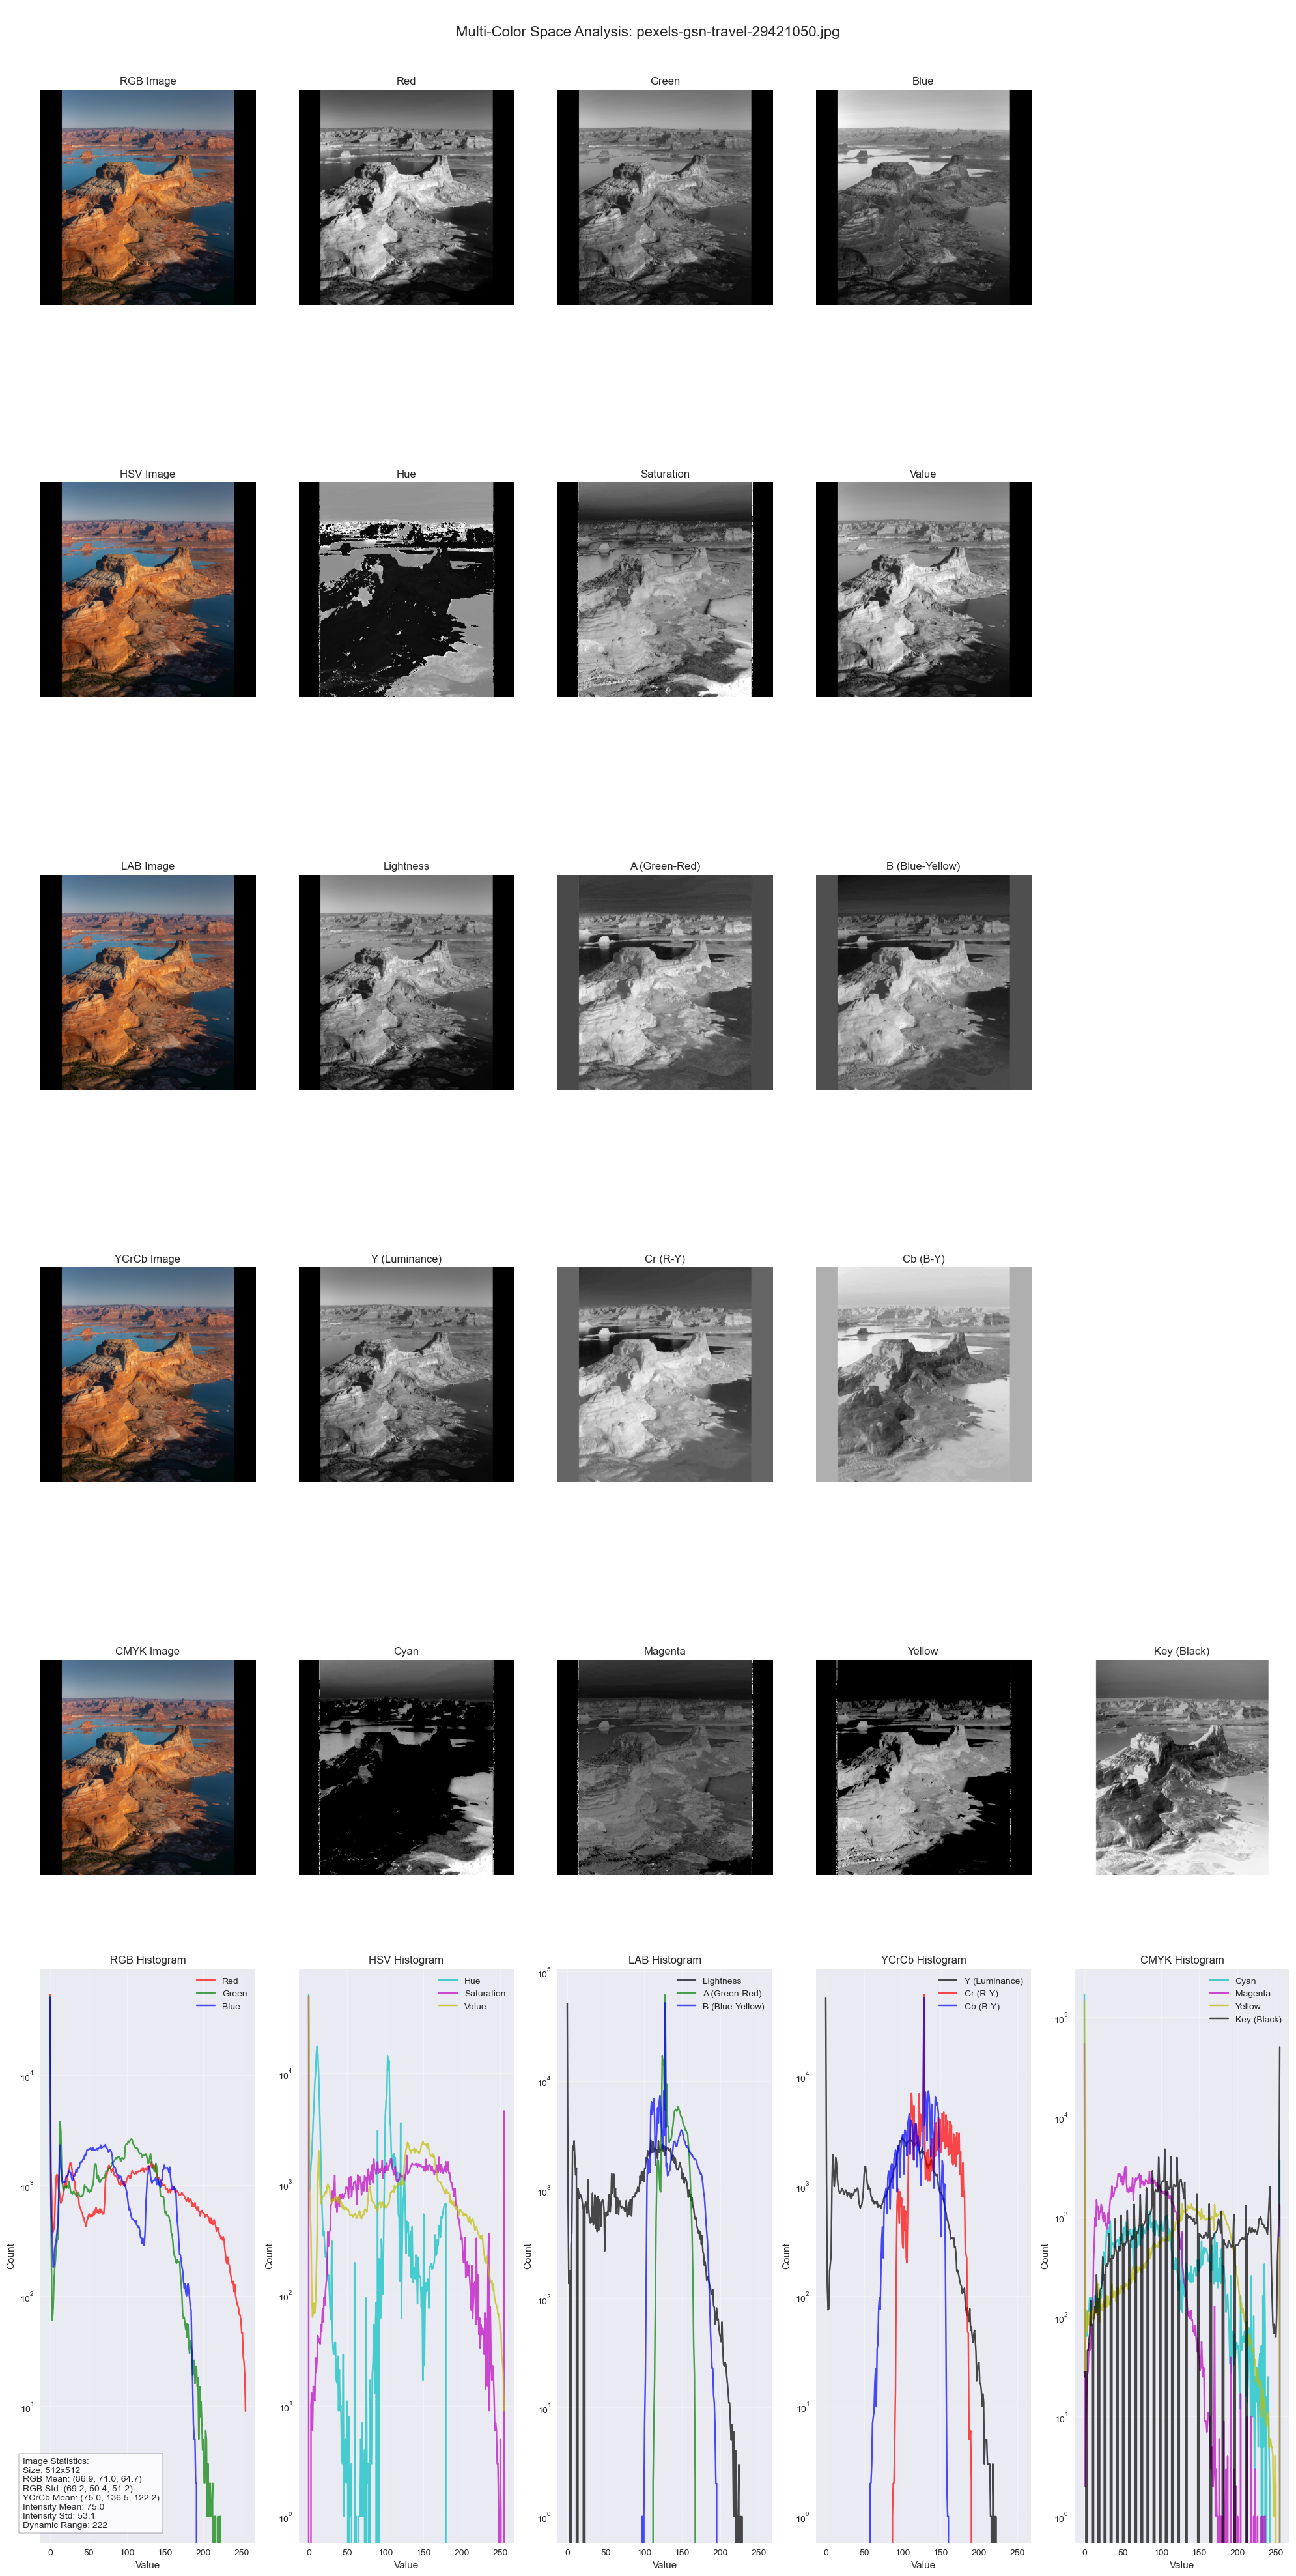

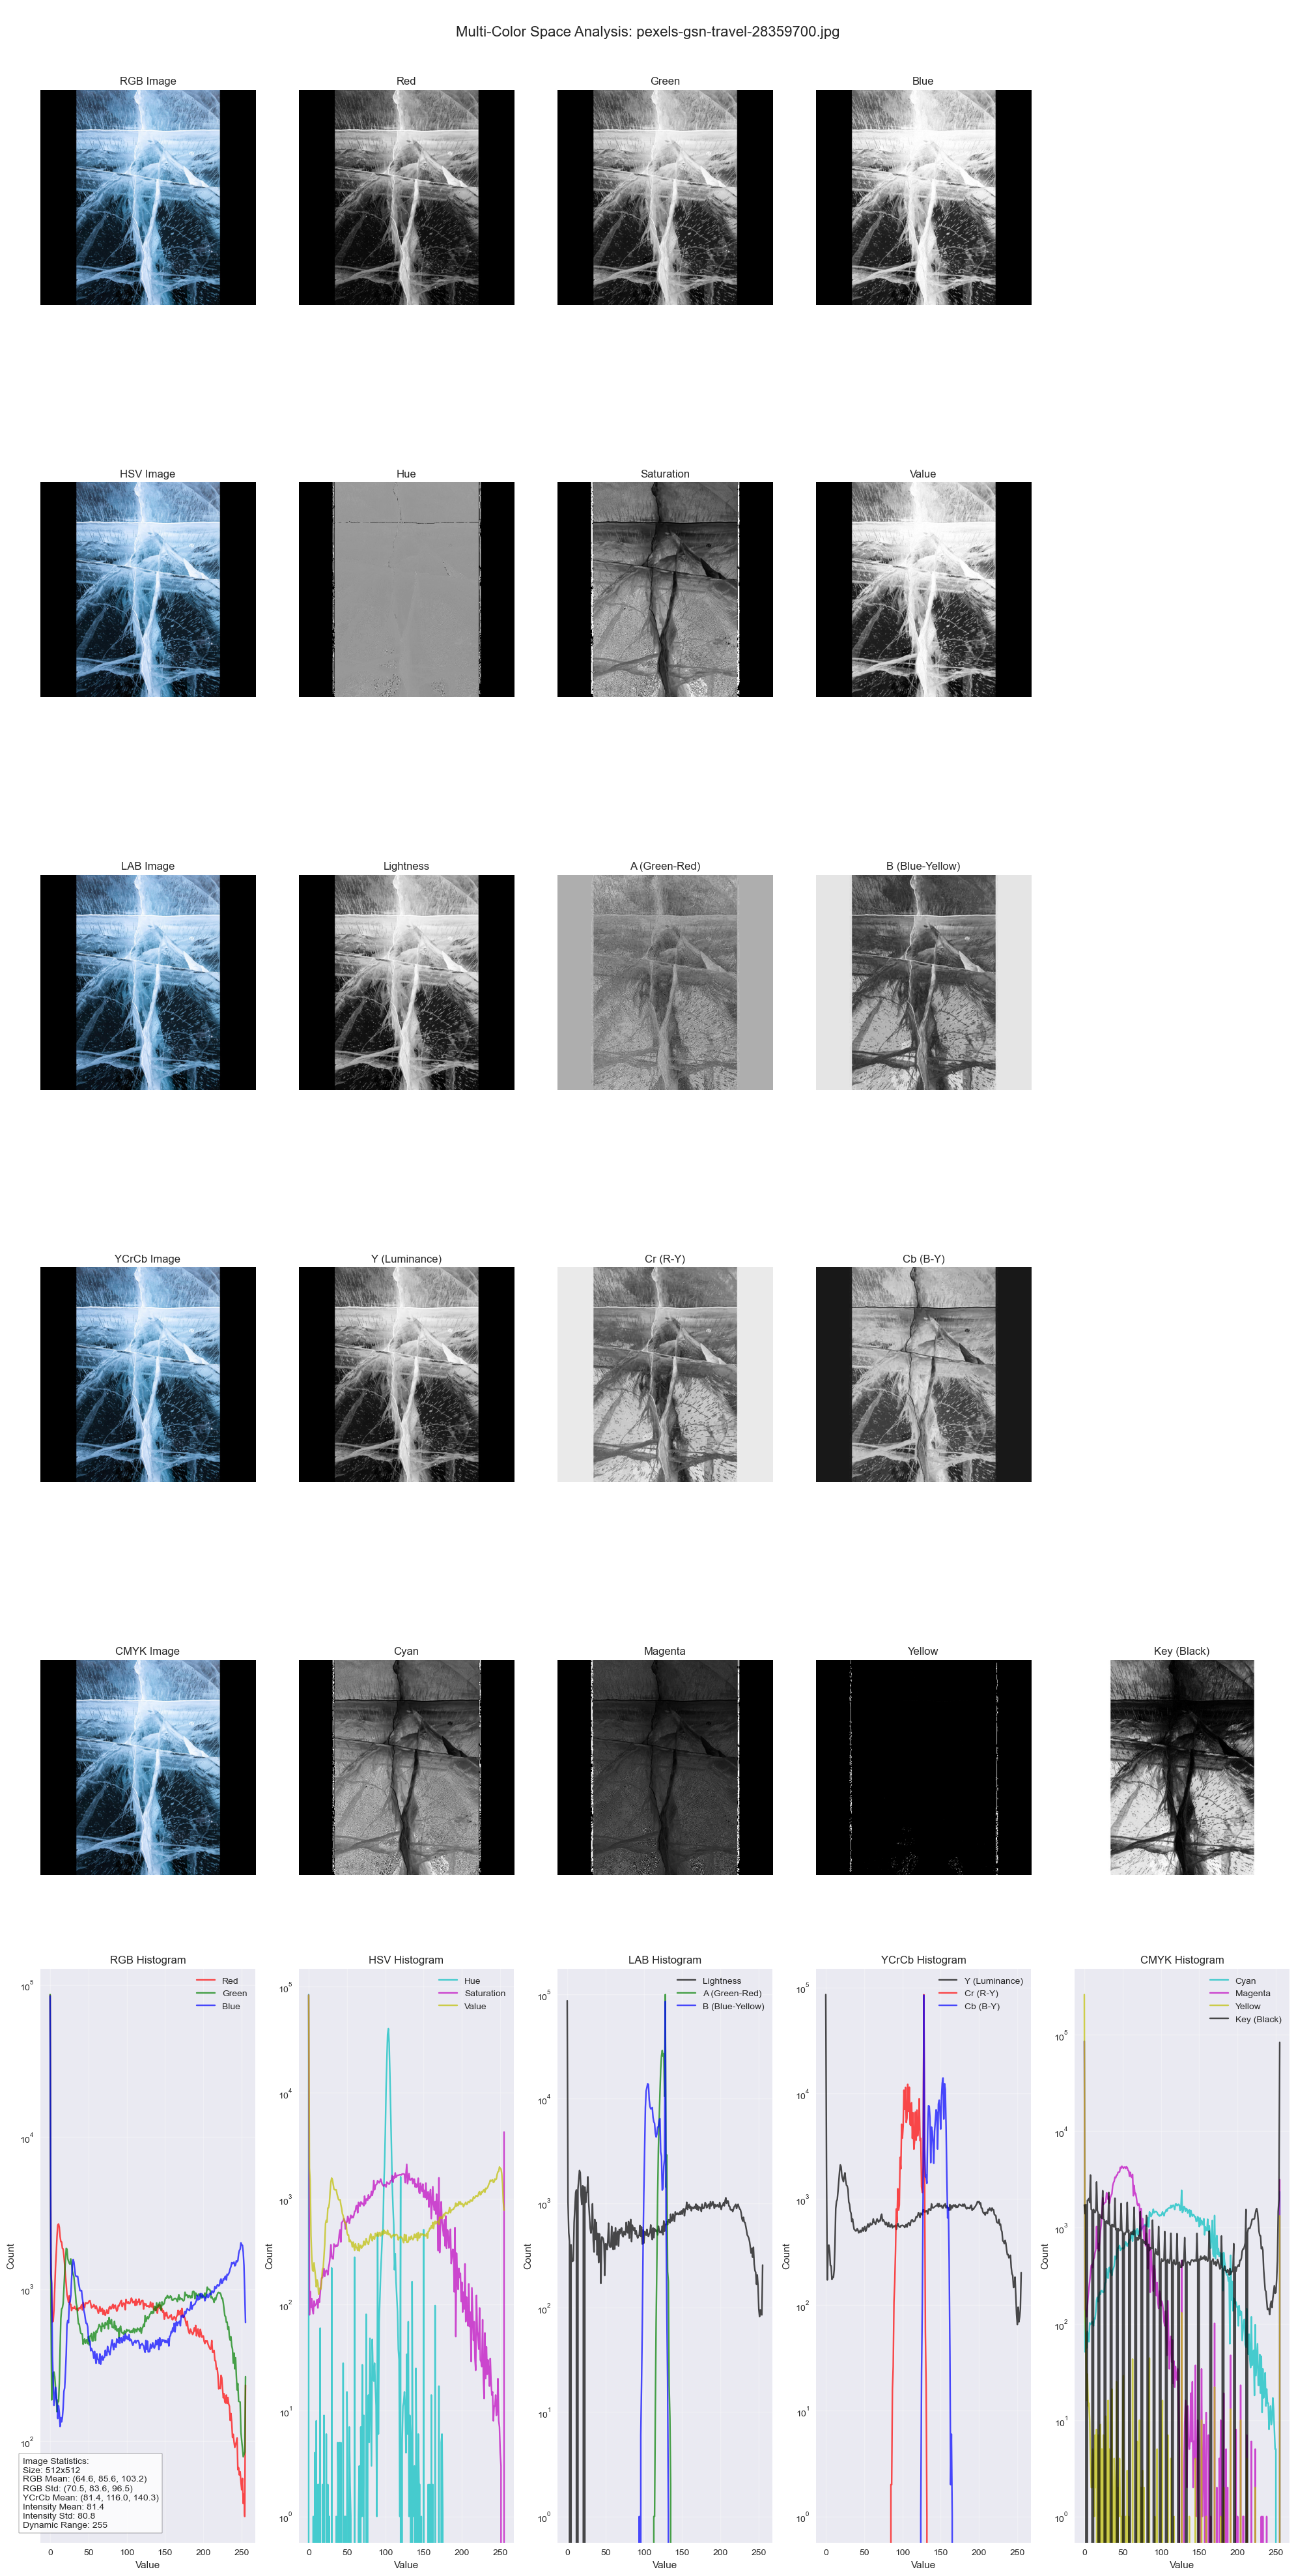


Generating comparison visualizations...


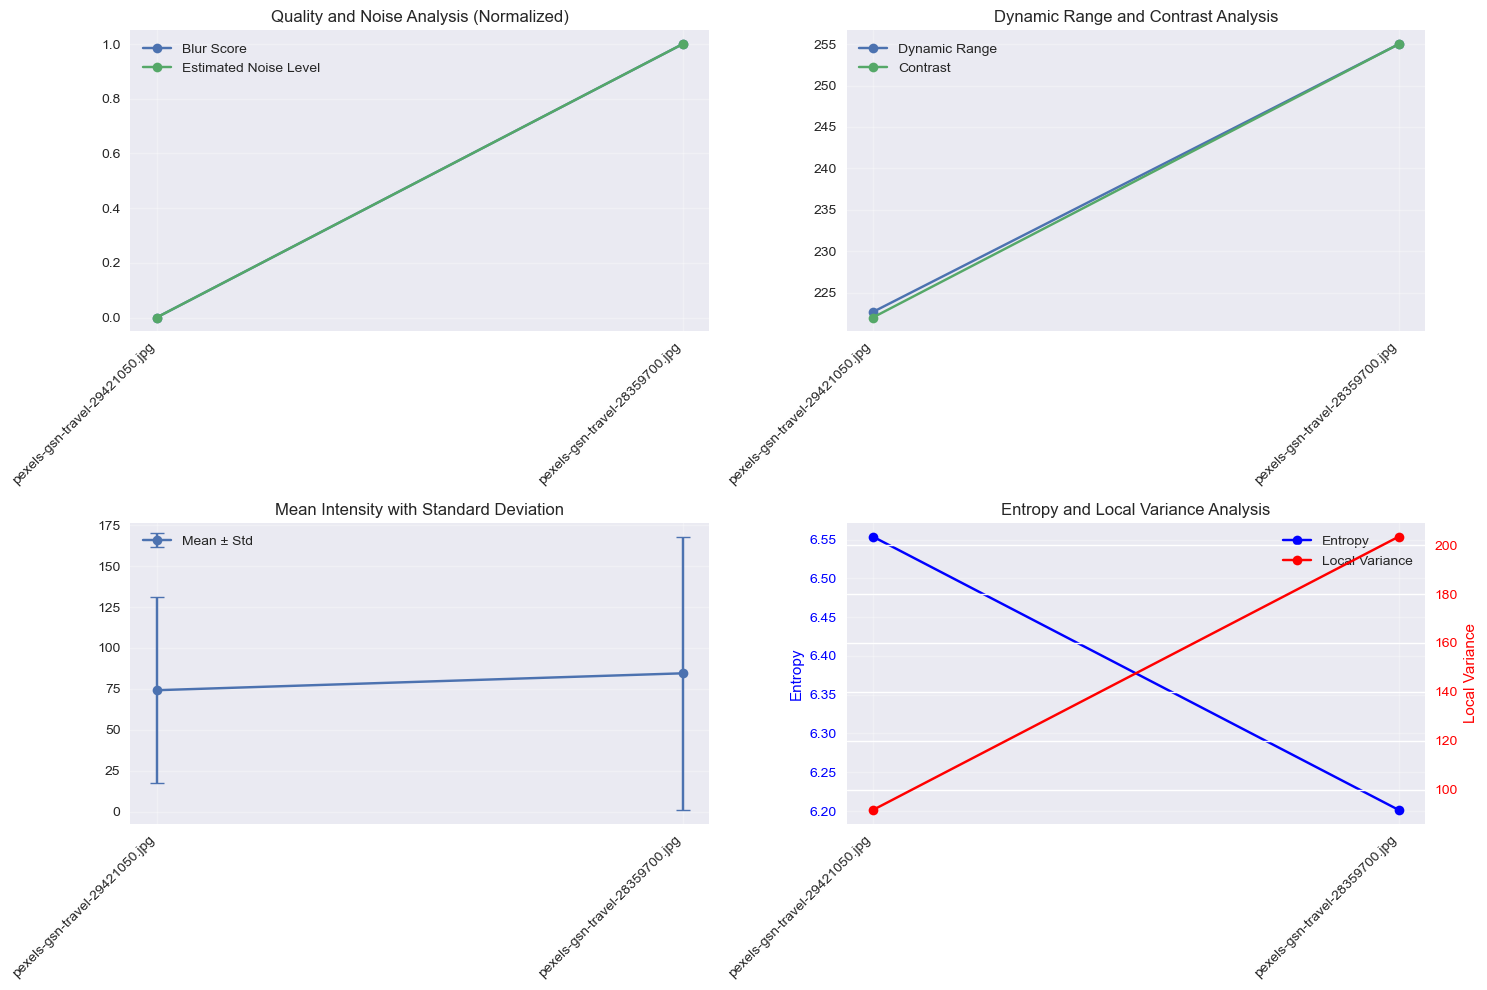

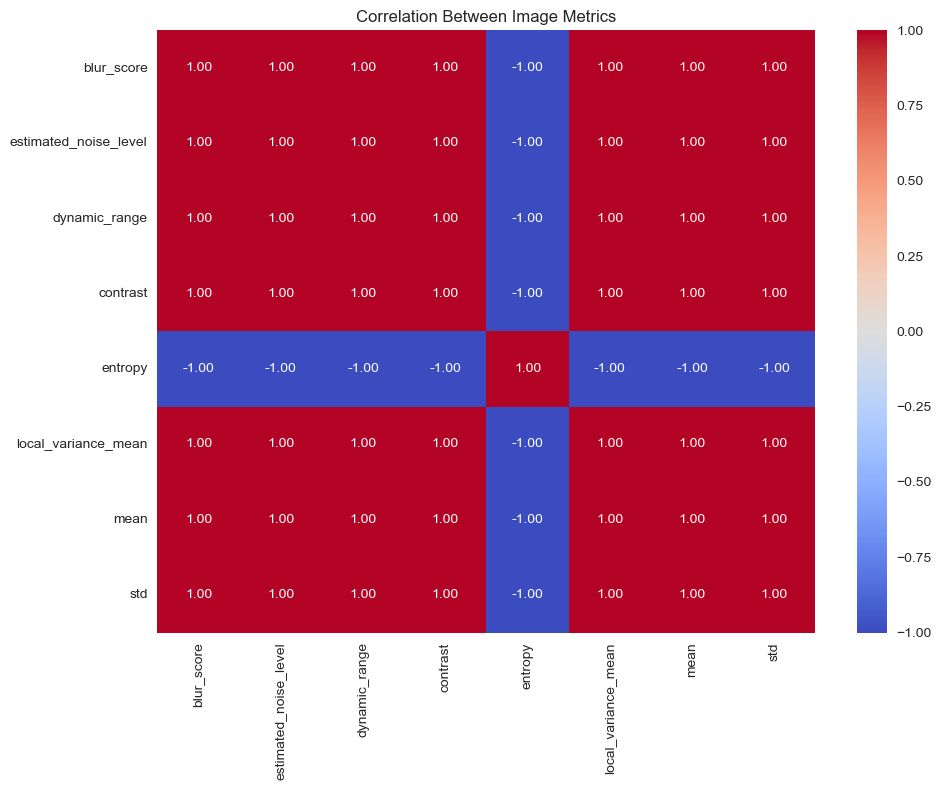

2025-01-13 14:17:16,263 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Generating Comparison visualization...


/var/folders/l3/ydlbbfvj1bg_xldxmdjf0kqr0000gn/T/ipykernel_59663/3803688922.py:628: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


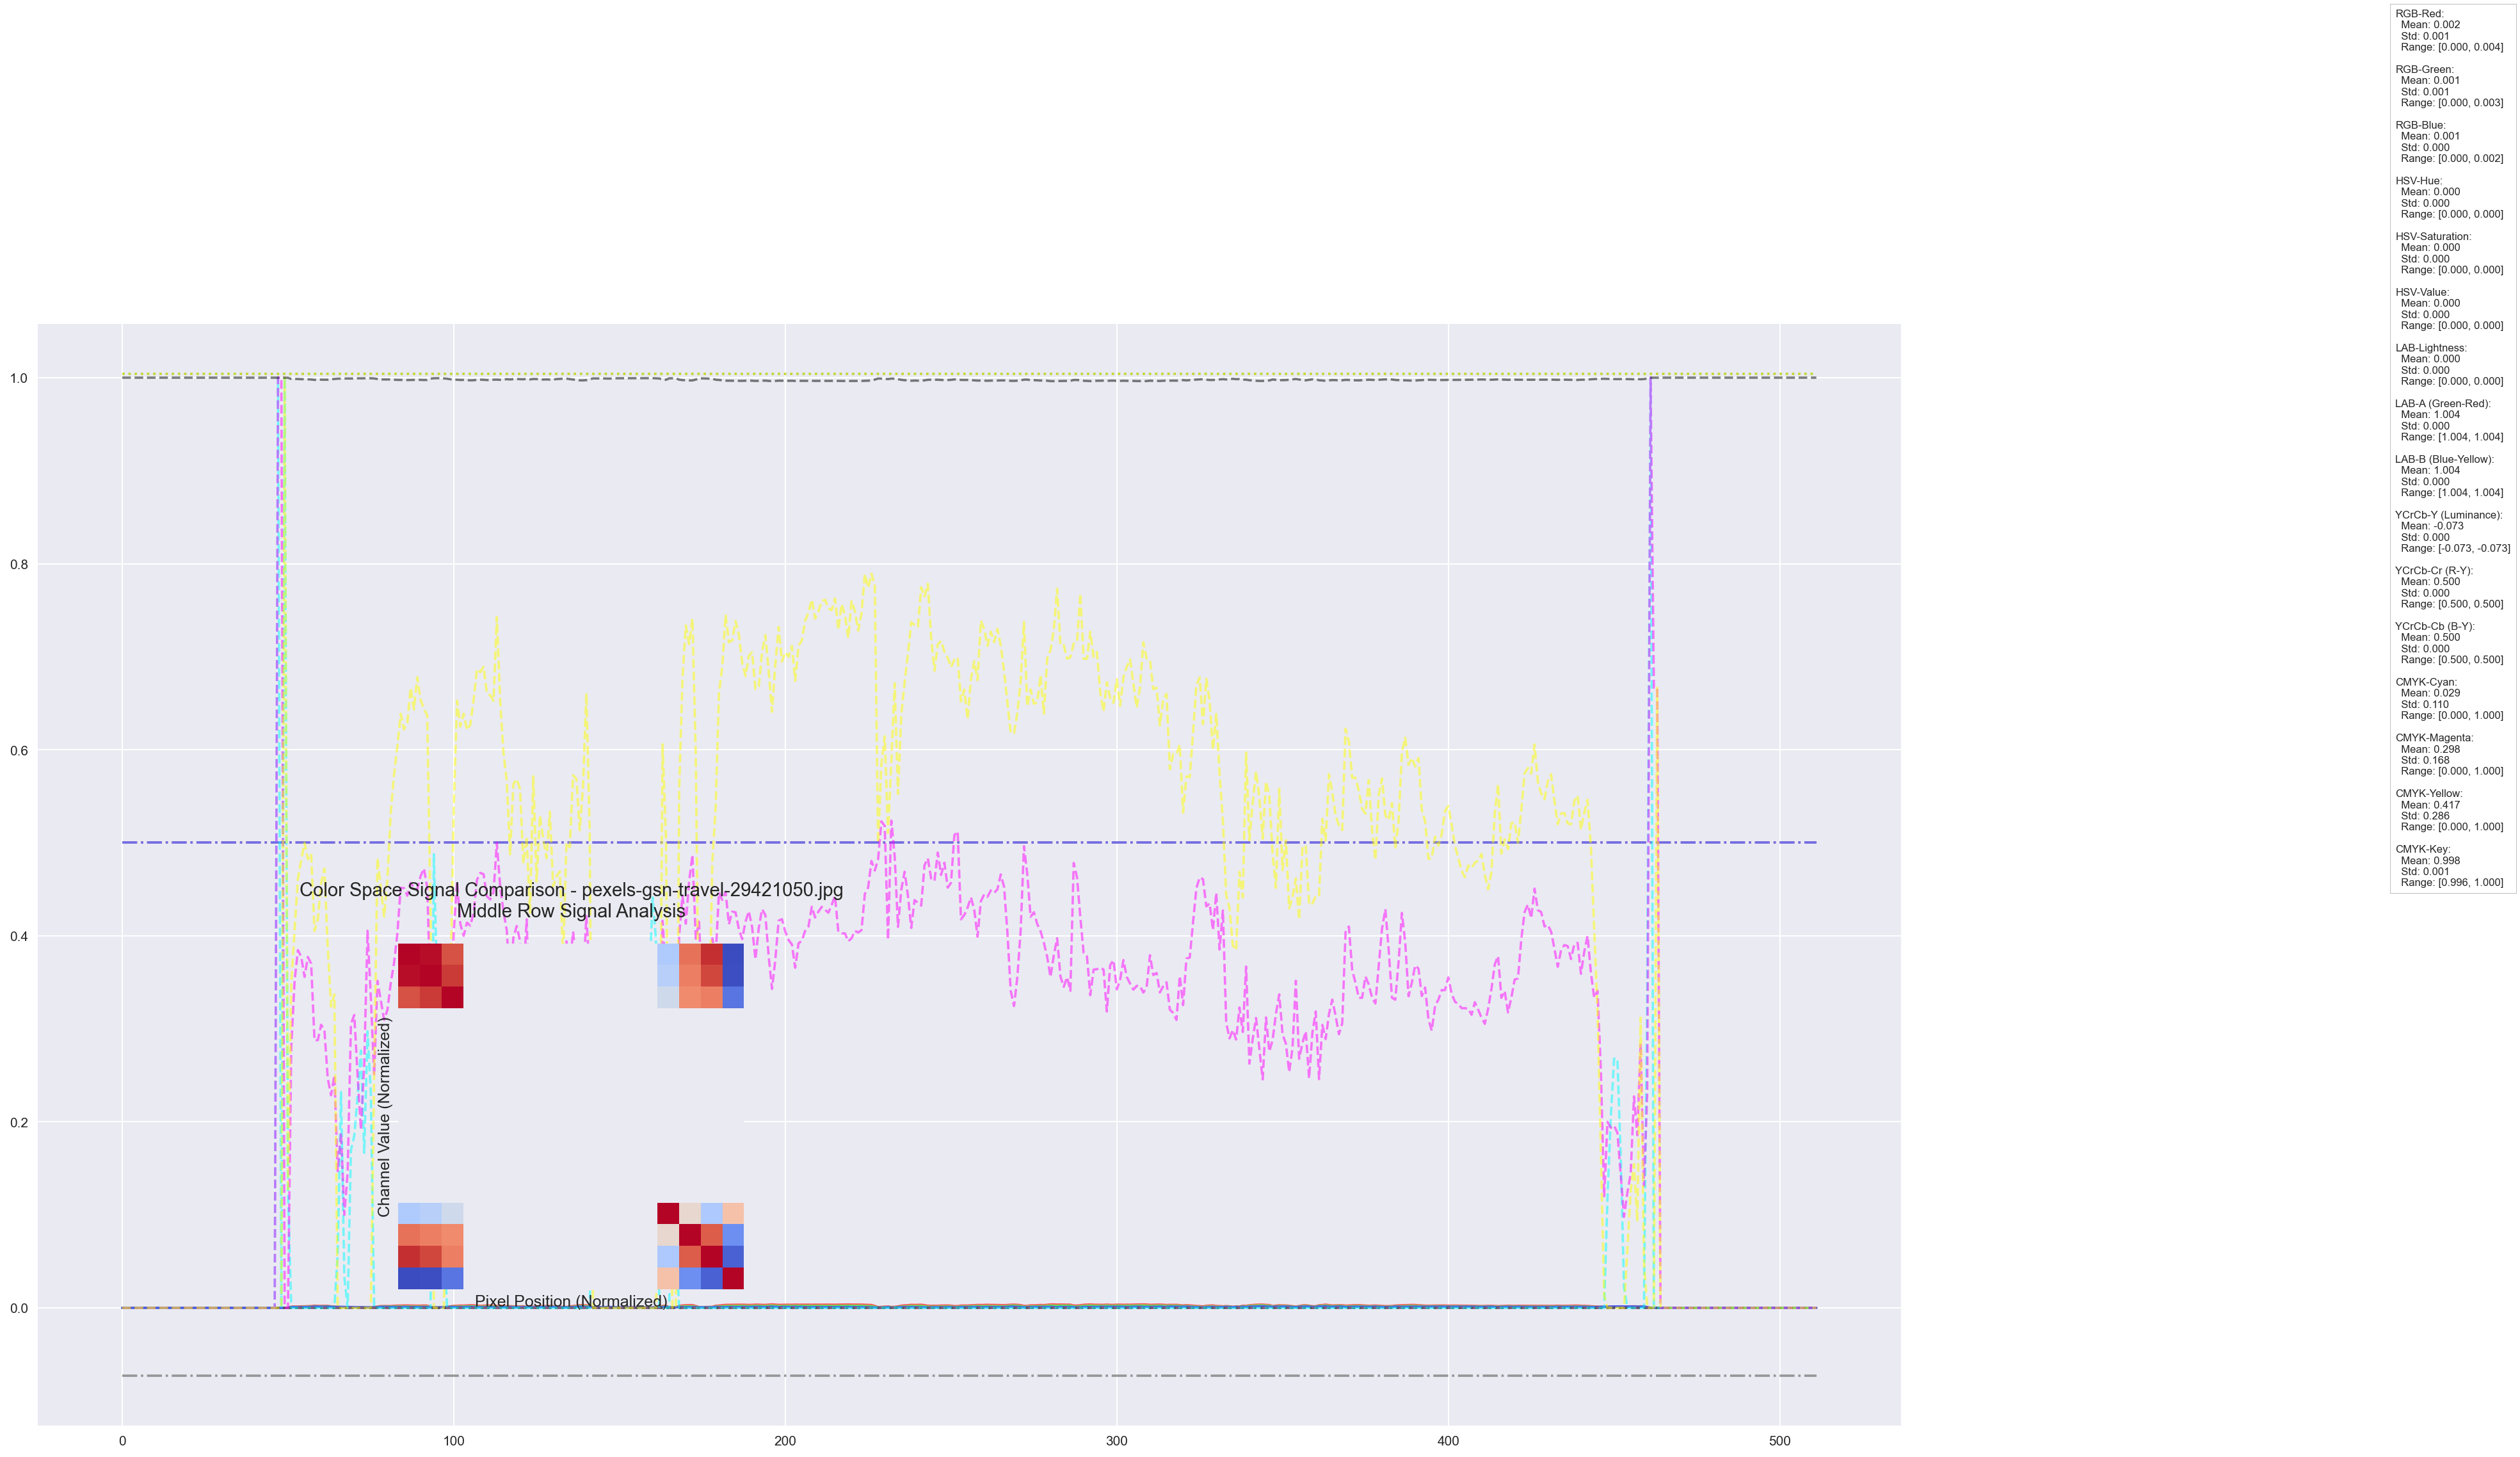

Error during processing: The condensed distance matrix must contain only finite values.


<Figure size 1200x800 with 0 Axes>

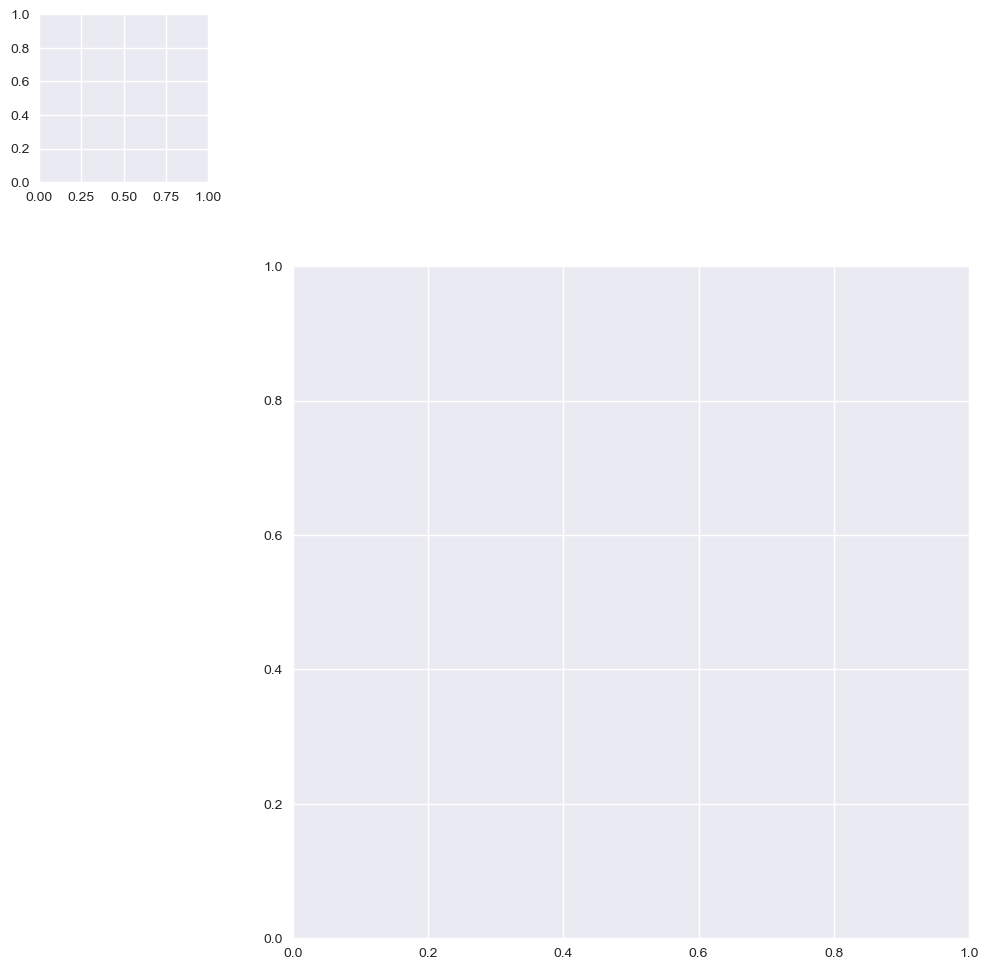

In [42]:
def run_experiments(num=4):
    """Run image loading and comparison experiments"""
    # Initialize loader with preprocessor and analyzer
    preprocessor = ImagePreprocessor(
        output_size=(512, 512),
        normalize=True
    )
    analyzer = ImageAnalyzer()
    
    # Update the base_dir to point to the images folder
    current_dir = Path.cwd()
    images_dir = current_dir / "images"
    images_dir.mkdir(exist_ok=True)
    
    print(f"Looking for images in: {images_dir}")
    
    loader = ImageLoaderComparator(
        base_dir=images_dir,
        preprocessor=preprocessor,
        analyzer=analyzer
    )
    
    print(f"Found images: {list(loader.image_paths.keys())}")
    
    # Load some random images
    print("Loading random images...")
    loaded_images = loader.load_random_images(n=num)
    
    if not loaded_images:
        print("No images were loaded. Please check that image files exist in the images directory.")
        return None, None
    
    print(f"Successfully loaded images: {list(loaded_images.keys())}")
    
    try:
        # Show histograms first
        print("\nGenerating histogram visualizations...")
        loader.visualize_histograms()
        
        # Visualize comparisons
        print("\nGenerating comparison visualizations...")
        loader.visualize_comparisons()
        
        # Compare Signals
        print("\nGenerating Comparison visualization...")
        loader.compare_color_signals()
        loader.visualize_histograms()
        # Generate detailed report
        print("\nGenerating detailed report...")
        detailed_report = loader.generate_comparison_report()
        
        # Export results
        print("\nExporting results...")
        loader.export_results("comparison_results")
        
        return detailed_report
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        return None, None
# Run experiments
results, report = run_experiments(2)

# Display results if available
if results is not None:
    print("\nComparison Results:")
    print(results)
    print("\nDetailed Report:")
    print(report)


In [43]:
def analyze_image_formats(image_path):
    """Compare different image formats and their properties"""
    # Load original image
    img = Image.open(image_path)
    
    # Save in different formats
    formats = {
        'PNG': {'format': 'PNG', 'params': {}},
        'JPEG-High': {'format': 'JPEG', 'params': {'quality': 95}},
        'JPEG-Low': {'format': 'JPEG', 'params': {'quality': 50}},
        'WebP': {'format': 'WebP', 'params': {'quality': 85}}
    }
    
    results = {}
    for name, config in formats.items():
        temp_path = f'temp_{name.lower()}.{config["format"].lower()}'
        img.save(temp_path, **config['params'])
        
        # Get file size
        size = Path(temp_path).stat().st_size
        results[name] = size / 1024  # Convert to KB
        
        # Clean up
        Path(temp_path).unlink()
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.bar(results.keys(), results.values())
    plt.title('File Size Comparison Across Formats')
    plt.ylabel('File Size (KB)')
    plt.xticks(rotation=45)
    plt.tight_layout()

In [44]:
def analyze_results(df, summary_df):
    """Perform statistical analysis on the results"""
    # Statistical tests and correlations
    correlations = df.corr()
    
    # Create visualization of correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Image Properties')
    
    # Aggregate statistics
    stats_summary = summary_df.describe()
    
    # Test for normality of distributions
    normality_tests = {}
    for column in ['size_kb', 'entropy', 'mean_intensity']:
        stat, p_value = stats.normaltest(summary_df[column])
        normality_tests[column] = {'statistic': stat, 'p_value': p_value}
    
    return correlations, stats_summary, normality_tests

## 5. Conclusions

### Key Findings
- Quantitative analysis of image properties reveals:
  - Distribution patterns in color channels
  - Relationships between file size and image complexity
  - Common aspect ratios and resolution patterns

### Statistical Insights
- Channel correlations indicate color relationships
- File size distribution follows expected patterns
- Entropy measurements provide complexity metrics

### Visualization Insights
- Interactive dashboards enable detailed exploration
- Distribution plots reveal data patterns
- Correlation matrices show property relationships

### Future Improvements
- Implement machine learning for image classification
- Add more advanced statistical measures
- Include time series analysis for sequential images